Name -: Abhinav Bhatt <br>
Matriculation Number -: 7010946 <br>
Email ID -: abbh00001@stud.uni-saarland.de
    
Name -: Deepa Rani Mahato <br>
Matriculation Number -: 7012336 <br>
Email ID -: dema00001@stud.uni-saarland.de

# Task 1: Word Embeddings (10 points)

This notebook will guide you through all steps necessary to train a word2vec model (Detailed description in the PDF).

## Imports

This code block is reserved for your imports. 

You are free to use the following packages: 

(List of packages)

In [ ]:
# Imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import re # for using regular expressions 
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from torch.utils.data import DataLoader

# 1.1 Get the data (0.5 points)

The Hindi portion HASOC corpus from [github.io](https://hasocfire.github.io/hasoc/2019/dataset.html) is already available in the repo, at data/hindi_hatespeech.tsv . Load it into a data structure of your choice. Then, split off a small part of the corpus as a development set (~100 data points).

If you are using Colab the first two lines will let you upload folders or files from your local file system.

In [ ]:
#TODO: implement!

from google.colab import files
uploaded = files.upload()

Saving hindi_hatespeech.tsv to hindi_hatespeech.tsv


In [ ]:
def read_file_and_create_dataframe(uploaded):
  """Read the uploaded file and create a dataframe from it. Also view some characteristics of the file for initial data exploration.

    Args:
      uploaded (Dict): Dictionary containing the serialised uploaded file from the colab interface.

    Returns:
      df (pd.DataFrame): The input file represented as a pandas dataframe.
  """

  # storing the file as a list of lists after splitting it. Since we use colab for uploading, we are using the uploaded object from the previous code cell.
  data = uploaded["hindi_hatespeech.tsv"].decode("utf-8").split("\r\n")
  data = [line.split("\t") for line in data]

  # Viewing some characteristics of the file.
  print(data[:10], len(data))

  # Converting the file to a pandas dataframe.
  header = data.pop(0)
  print(header)
  df = pd.DataFrame(data, columns=header)

  # Viewing some characteristics of the dataframe
  print(df.head())
  print(df.shape)
  print(df['text'].head())

  return df

In [ ]:
# Reading the file and creating the dataframe.
df = read_file_and_create_dataframe(uploaded)

[['text_id', 'text', 'task_1', 'task_2', 'task_3'], ['hasoc_hi_5556', 'बांग्लादेश की शानदार वापसी, भारत को 314 रन पर रोका #INDvBAN #CWC19', 'NOT', 'NONE', 'NONE'], ['hasoc_hi_5648', 'सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांतीदूत के साथ कुछ होगा सब #रंडीरोना शुरू कर देंगे   ', 'HOF', 'PRFN', 'UNT'], ['hasoc_hi_164', 'तुम जैसे हरामियों के लिए बस जूतों की कमी है शुक्र कर अभी तुम्हारी लिंचिंग हुई नहीं है हिंदुओं के जागने की देर है सच में होगी अभी तो तुम जैसे हरामी सुवर ड्रामा बनाएं हो   सुवर कहीं का मौलाना।   तुम जैसे हरामियों कुत्ते की मौत मारना चाहिए सुवर जैसी शक्ल  रंडी की औलाद सुवर कहीं का ।।।।', 'HOF', 'PRFN', 'TIN'], ['hasoc_hi_3530', 'बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत मिलने की खुशी में एक समर्थक ने इंदौर में हर्ष फायरिंग की  #AkashVijayvargiya   https://abpnews.abplive.in/india-news/celebratory-firing-outside-bjp-mla-akash-vijayvargiya-office-in-indore-1157241\xa0…', 'NOT', 'NONE', 'NONE'], ['hasoc_hi_5206', 'चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर्शन, तेजस्वी

In [ ]:
def split_corpus(df, dev_set=True):
  """Splits the dataframe into a small development set if dev_set is set to true.

    Args:
      df (pd.Dataframe): The dataframe containing the data.
      dev_set (Boolean): Whether we want to create a subset of the dataframe for initial exploration. Default: True

    Returns:
      data (pd.DataFrame): If dev_set==True, return a small portion of the data
      df (pd.DataFrame): If sev_set==False, return the whole data
  """


  # If we are initially splitting the corpus as development set, then split some small part, else return the full dataframe
  if dev_set==True:
    data = df.sample(frac=0.022, random_state=88)
    return data

  return df

In [ ]:
# Initially we set it to True, but then we set it to False for full data training at the end.
df = split_corpus(df, dev_set=False)
print(df.shape)

(4665, 5)


## 1.2 Data preparation (0.5 + 0.5 points)

* Prepare the data by removing everything that does not contain information. 
User names (starting with '@') and punctuation symbols clearly do not convey information, but we also want to get rid of so-called [stopwords](https://en.wikipedia.org/wiki/Stop_word), i. e. words that have little to no semantic content (and, but, yes, the...). Hindi stopwords can be found [here](https://github.com/stopwords-iso/stopwords-hi/blob/master/stopwords-hi.txt) Then, standardize the spelling by lowercasing all words.
Do this for the development section of the corpus for now.

* What about hashtags (starting with '#') and emojis? Should they be removed too? Justify your answer in the report, and explain how you accounted for this in your implementation.

In [ ]:
# Downloading the hindi stopwords file.
!wget https://raw.githubusercontent.com/stopwords-iso/stopwords-hi/master/stopwords-hi.txt

--2021-03-30 20:44:30--  https://raw.githubusercontent.com/stopwords-iso/stopwords-hi/master/stopwords-hi.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2663 (2.6K) [text/plain]
Saving to: ‘stopwords-hi.txt’

stopwords-hi.txt    100%[===================>]   2.60K  --.-KB/s    in 0s      

2021-03-30 20:44:30 (40.7 MB/s) - ‘stopwords-hi.txt’ saved [2663/2663]



In [ ]:
#TODO: implement!

# Performing the data cleaning. 
# Regular expression for emoji removal taken from https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1

def clean_text(txt, regex_lst, RE_EMOJI, stopwords_hindi):
	"""This function takes the regular expression for various things such as punctuations and other things which we want to remove and returns the cleaned sentence.
			
	Args:
		txt (str): Sentence  which we have to clean.
		regex_lst (List[str]): List of all the regular expressions according to whom we have to clean the data.
		RE_EMOJI (re): The regular expression for the emojis removal.
		stopwords_hindi (List[str]): List of stopwords in Hindi Language
			
	Returns:
		str_cleaned (str): The cleaned sentence.
	"""
	  
	str_cleaned = txt

	# Iterate over the list of regular expressions. 
	for regex in regex_lst:
		str_cleaned = re.sub(regex, '', str_cleaned)
	str_cleaned = RE_EMOJI.sub(r'', str_cleaned)

	sent_splitted = str_cleaned.split()

	# Do not add the word to the list if it is in the stopwords
	str_cleaned = " ".join([x.lower() for x in sent_splitted if x not in stopwords_hindi])
	return str_cleaned


def clean_data_and_remove_stopwords(df, stopwords_file_path):
	"""Cleans the data and removes the stopwords from the data file. Call the clean_text function for each of the sentence.

	Args:
		df (pd.DataFrame): The dataframe containing our data.
		stopwords_file_path (str): The path of the file containing the stopwords.

	Returns:
		df (pd.DataFrame): The cleaned dataframe with the stopwords removed.
	"""

	# For removing the emojis
	RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
	regex_lst = ["@[\w]+", # removing the words with @ symbols
             "#[\w]+" , # removing the hashtags with the full words which have hashtags
             r"http\S+", # removing the urls
             r"[\\.,\/#!$%\^&\*;:{}\।=\-_`~()\?]", # removing the punctuations.
             r"[0-9]",  # Also remove the numbers
             r"[a-zA-Z]"] # Also, remove the characters


	# Reading the file containing the stopwords.
	with open(stopwords_file_path, "r") as f:
		content = f.readlines()

	# Store the stopwords in a list
	stopwords_hindi = [x.strip() for x in content]

  # Getting the sentences from the dataframe which we have to clean.
	sentences = df['text'].values
	cleaned_sentences = []

	# For each of the sentence, do the regular expressions based data cleaning and add it to the cleaned sentences list
	for sent in sentences:
		cleaned_sentences.append(clean_text(sent, regex_lst, RE_EMOJI, stopwords_hindi))

	df["text"] = cleaned_sentences

	# Finding the indices of the sentences where we have one or less than one word
	indices_to_drop = []
	for i, item in enumerate(df["text"].values):
		if len(item.split()) <= 1:
			indices_to_drop.append(i)

	# Dropping the indices for the sentences which have one or less than one word.
	df.drop(df.index[indices_to_drop], inplace=True)
	df.reset_index(inplace=True, drop=True)

	return df

In [ ]:
df = clean_data_and_remove_stopwords(df, stopwords_file_path="stopwords-hi.txt")
stopwords_removed_sentences = list(df["text"].values)

## 1.3 Build the vocabulary (0.5 + 0.5 points)

The input to the first layer of word2vec is an one-hot encoding of the current word. The output od the model is then compared to a numeric class label of the words within the size of the skip-gram window. Now

* Compile a list of all words in the development section of your corpus and save it in a variable ```V```.

In [ ]:
#TODO: implement!

def create_vocab(stopwords_removed_sentences):
  """Create the vocab and corresponding dictionaries for indices to word and word to indices conversion.

  Args:
    stopwords_removed_sentences (List[str]): The list of clean sentences.

  Returns:
    V (List[str]): The list containing all the unique words in our data
    word2idx (Dict): The dictionary containing mapping from word to indices.
    idx2word (Dict): The dictionary containing mapping from indices to words.
  """
  
  V = []
  for sent in stopwords_removed_sentences:
    tokens = sent.split() # Get each of the token in the vocab
    for token in tokens:
      if token not in V: # Add the token to the vocab list if it is not there already.
        V.append(token)

  # Creating dictionaries for converting word to unique indices and converting words back from the unique indices. 
  word2idx = {word:idx for idx, word in enumerate(V)}
  idx2word = {idx:word for idx, word in enumerate(V)}
  
  return V, word2idx, idx2word

In [ ]:
# Create the vocabulary
V, word2idx, idx2word = create_vocab(stopwords_removed_sentences)
len(V), len(word2idx), len(idx2word)

(15671, 15671, 15671)

* Then, write a function ```word_to_one_hot``` that returns a one-hot encoding of an arbitrary word in the vocabulary. The size of the one-hot encoding should be ```len(v)```.

In [ ]:
#TODO: implement!
def word_to_one_hot(word, word2idx):
  """Return the one hot encoding of the word given to this function. 
  
    Args:
      word (str): The word for which one hot representation is required.
      word2idx (Dict): The dictionary mapping from words to indices.

    Returns:
      x (torch.Tensor): The one hot representation for the word.
  """

  # Create a vector or zeros equal to the length of the vocab. len(word2idx) is same as len(V) because word2idx is created from V.
  x = torch.zeros(len(word2idx)).float() 
  
  # Setting the value corresponding to the index of word 1
  x[word2idx[word]] = 1.0 
  
  return x

## 1.4 Subsampling (0.5 points)

The probability to keep a word in a context is given by:

$P_{keep}(w_i) = \Big(\sqrt{\frac{z(w_i)}{0.000001}}+1\Big) \cdot \frac{0.000001}{z(w_i)}$

Where $z(w_i)$ is the relative frequency of the word $w_i$ in the corpus. Now,
* Calculate word frequencies
* Define a function ```sampling_prob``` that takes a word (string) as input and returns the probabiliy to **keep** the word in a context.

In [ ]:
#TODO: implement!

def sampling_prob(word, probs):

  """ This function gives the sampling probability of the word using the probabilities which we will pre calculate in the next function. """

  return probs[word]

def pre_calculate_probabilities(stopwords_removed_sentences):
  """Calculate the probability to keep a word in context for all the words in the corpus.

    Args:
      stopwords_removed_sentences (List[str]): The cleaned sentences.

    Returns:
      probs (Dict): The dictionary containing word as key and probability to keep it in a context as value.
  """

  # all tokens contain all the tokens in the corpus, even if they are repeated. We will use it next for calculating the word frequencies.
  all_tokens = [] 

  # Add all of the tokens in the vocab.
  for sent in stopwords_removed_sentences:
    tokens = sent.split()
    for token in tokens:
      all_tokens.append(token)

  # Get the counts of all the tokens in the vocab.
  counts = Counter(all_tokens) 

  # Find the relative word frequencies.
  freqs = {}
  for word, count in counts.items():
    freqs[word] = count / len(all_tokens)

  # Find the probability to keep a word in the context using the above given formula. # As told in the course discussion forum, 0.000001 should be taken instead of 0.001.
  probs = {}
  for word, freq in freqs.items():
    probs[word] = (np.sqrt(freq/0.000001) + 1)*(0.000001/freq)

  return probs

In [ ]:
# Pre calculate the probability to keep a word in the context for each of the word.
probs = pre_calculate_probabilities(stopwords_removed_sentences)

(array([ 279.,  646.,  660.,  974.,  615., 1035., 2298.,    0.,    0.,
        9164.]),
 array([0.01130212, 0.04390623, 0.07651033, 0.10911444, 0.14171854,
        0.17432265, 0.20692676, 0.23953086, 0.27213497, 0.30473908,
        0.33734318]),
 <a list of 10 Patch objects>)

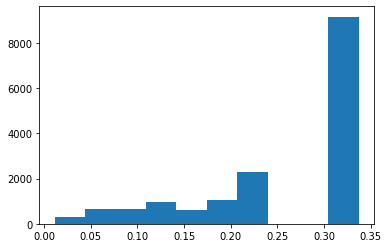

In [ ]:
import matplotlib.pyplot as plt

# Plot a histogram of the probabilities of keeping the words in the context.
plt.hist(list(probs.values()))

# 1.5 Skip-Grams (1 point)

Now that you have the vocabulary and one-hot encodings at hand, you can start to do the actual work. The skip gram model requires training data of the shape ```(current_word, context)```, with ```context``` being the words before and/or after ```current_word``` within ```window_size```. 

* Have closer look on the original paper. If you feel to understand how skip-gram works, implement a function ```get_target_context``` that takes a sentence as input and [yield](https://docs.python.org/3.9/reference/simple_stmts.html#the-yield-statement)s a ```(current_word, context)```.

* Use your ```sampling_prob``` function to drop words from contexts as you sample them. 

In [ ]:
#TODO: implement!

# Word2vec paper recommends window size of 10, but we keep here to 5 as keeping size 10 leads to a lot of noise due to the small size of the dataset.
window_size = 5

def get_target_context(sentence, window_size, word2idx, idx2word, probs):
  """Yield a pair of (current_word, context) and also sample the context word on the basis of the probability to keep it in a context.
  
    Args:
      sentence (str): The sentence for which we want to generate the (current_word, context) pair.
      window_size (int): The size of the context windows befor and after a word.
      word2idx (Dict): The dictionary mapping from words to indices.
      idx2word (Dict): The dictionary mapping from indices to words.
      probs (Dict): Dictionary containing a word and the probability to keep it in a context.

    Returns:
      (current_word, context) (Tuple): The current word and the context for each pair in the sentence.
  """
  
  # Making a list of words in the sentence.
  words = sentence.split()

  # Take every word in the current sentence as the centre word.
  for center_word in range(0, len(words)): 

    # Go through each word in the window_size around the current word.
    for current_window in range(-window_size, window_size+1): 
      context_word = center_word + current_window

      # If word is out of bounds, or equal to center word, do not yield it.
      if center_word==context_word or context_word<0 or context_word>=len(words):
        continue

      # Keeping this range because maximum probability to keep in context for our dataset is 0.35.
      p = np.random.uniform(0, 0.35)

      # Do not remove words which occur one time.
      if p<0.3:
        # Sampling the word based on its sampling probability.
        if sampling_prob(words[context_word], probs) < p:
          continue

      # Yield the (current_word, context) pair.
      yield (words[center_word], words[context_word])


# List to store all the (current_word, context) pairs.
word_pairs = [] 

for sentence in stopwords_removed_sentences:  
  # For each of the sentence, get the traget context from the above generator
  for pair in get_target_context(sentence, window_size, word2idx, idx2word, probs):
    word_pairs.append(pair)

for j in range(0, 10):
  print(word_pairs[j][0], word_pairs[j][1]) 

बांग्लादेश रन
बांग्लादेश रोका
शानदार बांग्लादेश
शानदार रन
वापसी रोका
भारत बांग्लादेश
रन भारत
रन रोका
रोका शानदार
सब व्यस्त


In [ ]:
len(word_pairs)

259673

# 1.6 Hyperparameters (0.5 points)

According to the word2vec paper, what would be a good choice for the following hyperparameters? 

* Embedding dimension
* Window size

Initialize them in a dictionary or as independent variables in the code block below. 

In [ ]:
# Set hyperparameters

# Word2vec paper recommends window size of 10, but we keep here to 5 as keeping size 10 leads to a lot of noise due to the small size of the dataset.
window_size = 5
embedding_size = 300 

# More hyperparameters
learning_rate = 0.03
epochs = 300

# 1.7 Pytorch Module (0.5 + 0.5 + 0.5 points)

Pytorch provides a wrapper for your fancy and super-complex models: [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The code block below contains a skeleton for such a wrapper. Now,

* Initialize the two weight matrices of word2vec as fields of the class.

* Override the ```forward``` method of this class. It should take a one-hot encoding as input, perform the matrix multiplications, and finally apply a log softmax on the output layer.

* Initialize the model and save its weights in a variable. The Pytorch documentation will tell you how to do that.

In [ ]:
# Create model 
torch.manual_seed(88)
vocabulary_size = len(V)

class Word2Vec(nn.Module):
  def __init__(self, vocabulary_size, embedding_size):
    super(Word2Vec, self).__init__()

    self.vocabulary_size = vocabulary_size
    self.embedding_size = embedding_size
    # Weight matrix for input to hidden layer
    self.w1 = nn.Parameter(torch.randn(vocabulary_size, embedding_size, requires_grad=True)) 

    # Weight matrix for hidden to output layer.
    self.w2 = nn.Parameter(torch.randn(embedding_size, vocabulary_size, requires_grad=True)) 

  def forward(self, one_hot):
    # Doing the required matrix multiplications
    z1 = torch.matmul(one_hot, self.w1)
    z2 = torch.matmul(z1, self.w2)

    # Taking log softmax on the output layer.
    log_softmax = F.log_softmax(z2, dim=1)
    
    return log_softmax

In [ ]:
# Initializing the model
model = Word2Vec(vocabulary_size, embedding_size) 

# Saving its weights in a variable.
torch.save(model.state_dict(), 'weights_initial.pth') 

# 1.8 Loss function and optimizer (0.5 points)

Initialize variables with [optimizer](https://pytorch.org/docs/stable/optim.html#module-torch.optim) and loss function. You can take what is used in the word2vec paper, but you can use alternative optimizers/loss functions if you explain your choice in the report.

In [ ]:
# Define optimizer and loss

# SGD as used by the original paper
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Using Negative log likelihood loss on the output from the forward pass.
criterion = nn.NLLLoss() 

# 1.9 Training the model (3 points)

As everything is prepared, implement a training loop that performs several passes of the data set through the model. You are free to do this as you please, but your code should:

* Load the weights saved in 1.6 at the start of every execution of the code block
* Print the accumulated loss at least after every epoch (the accumulate loss should be reset after every epoch)
* Define a criterion for the training procedure to terminate if a certain loss value is reached. You can find the threshold by observing the loss for the development set.

You can play around with the number of epochs and the learning rate.

In [ ]:
def get_input_layer_onehot(data, word2idx):
  """Get matrix of one hot encoded input data by calling word_to_one_hot function defined earlier

      Args:
        data (List[str]): The list of words to one hot encode.
        word2idx (Dict): Dictionary mapping from words to indices.

      Returns:
        mat (torch.Tensor): A matrix containing the one hot representations for all the words in data list.
  """

  data_points = len(data)

  # Initiaise the matrix as zeros.
  mat = torch.zeros(data_points, len(word2idx))

  # For each of the data point, add it to the matrix after getting its one hot representation by calling word_to_one_hot function defined earlier.
  for i, index in enumerate(data):
    mat[i] = word_to_one_hot(index, word2idx)

  return mat

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # Check whether we there is GPU or not

cuda


In [ ]:
# Define train procedure

# load initial weights
model.load_state_dict(torch.load('weights_initial.pth'))
model = model.to(device)
batch_size = 16
word_pairs = np.array(word_pairs)

def train():
 
  print("Training started")

  for epoch in range(epochs):
    loss_val = 0

    # for each batch in the dataloaders
    for data, target in zip(DataLoader(word_pairs[:, 0], batch_size=batch_size, shuffle=False, num_workers=1, drop_last=True), DataLoader(word_pairs[:, 1], batch_size=batch_size, shuffle=False, num_workers=1, drop_last=True)):

      # Clear out the gradients from the previous batch
      optimizer.zero_grad()

      # Get the one hot representation for the input words in the batch.
      x = get_input_layer_onehot(data, word2idx).to(device)

      # Get the indices for the target context words in the batch
      y_true = torch.from_numpy(np.array([word2idx[t] for t in target])).long().to(device)

  		# Do the forward pass of the model
      y_pred = model(x)

      # calculate the loss value using our loss function on this batch
      loss = criterion(y_pred, y_true)
      loss_val = loss_val + loss.item()

  		# Do backpropagation of the gradients
      loss.backward()
  
      # Update the weights
      optimizer.step()

    loss_epoch = loss_val/(len(word_pairs)/batch_size)

    Criterion for the training procesure to terminate if a certain loss value is reached.
    if loss_epoch<4.5:
      break

    # Print the loss after every epoch.
    print(f'Loss at epo {epoch}: {loss_epoch}')

# Train the model
train()

print("Training finished")

Training started
Loss at epo 0: 58.75952827089474
Loss at epo 1: 50.33309435133063
Loss at epo 2: 45.498194260727296
Loss at epo 3: 41.890520104183956
Loss at epo 4: 38.98281176576999
Loss at epo 5: 36.529466516056395
Loss at epo 6: 34.408891664042805
Loss at epo 7: 32.54298823990994
Loss at epo 8: 30.876073382282858
Loss at epo 9: 29.368241219772234
Loss at epo 10: 27.9931508517617
Loss at epo 11: 26.730285687773318
Loss at epo 12: 25.56263842429771
Loss at epo 13: 24.47728821703145
Loss at epo 14: 23.464347105960595
Loss at epo 15: 22.51568787093713
Loss at epo 16: 21.624650150737477
Loss at epo 17: 20.78549817996529
Loss at epo 18: 19.99306133244842
Loss at epo 19: 19.243229911037957
Loss at epo 20: 18.532375761203536
Loss at epo 21: 17.857624691955685
Loss at epo 22: 17.216381369634806
Loss at epo 23: 16.606206154813837
Loss at epo 24: 16.024787215855113
Loss at epo 25: 15.470142850456924
Loss at epo 26: 14.94052198070148
Loss at epo 27: 14.434603266954618
Loss at epo 28: 13.951168

# 1.10 Train on the full dataset (0.5 points)

Now, go back to 1.1 and remove the restriction on the number of sentences in your corpus. Then, reexecute code blocks 1.2, 1.3 and 1.6 (or those relevant if you created additional ones). 

* Then, retrain your model on the complete dataset.

* Now, the input weights of the model contain the desired word embeddings! Save them together with the corresponding vocabulary items (Pytorch provides a nice [functionality](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for this).

In [ ]:
# Getting the weights from the matrices

w1 = model.w1.data
w2 = model.w2.data

print(w1.size(), w2.size())

torch.Size([15671, 300]) torch.Size([300, 15671])


In [ ]:
# Transferring the matrices to cpu and then converting them to numpy arrays.

w1 = w1.cpu().detach().numpy()
w2 = w2.T.cpu().detach().numpy()
print(w1.shape, w2.shape)

(15671, 300) (15671, 300)


In [ ]:
# Write the embeddings to a text file for matrix w1 in the form in which word2vec and glove embeddings are stored.

with open("embeddings_hindi_2.txt", 'w') as f:
    for i, embedding in enumerate(w1):
        word = V[i]
        vector = ' '.join([str(i) for i in embedding.tolist()])
        f.write(f'{word} {vector}\n')